# Uncertainty and Sensitivity Analyses <a class="anchor" id="top"></a>

* **Prepared by:**

    - [Yalin Li](https://qsdsan.readthedocs.io/en/latest/authors/Yalin_Li.html)

* **Covered topics:**

    - [1. Model, Parameter, and Metric](#s1)
    - [2. Perform Uncertainty and Sensitivity Analyses](#s2)
    
- **Video demo:**

    - [Hannah Lohman](https://qsdsan.readthedocs.io/en/latest/authors/Hannah_Lohman.html)

To run tutorials in your browser, go to this [Binder page](https://mybinder.org/v2/gh/QSD-Group/QSDsan/main?filepath=%2Fdocs%2Fsource%2Ftutorials).

You can also watch a video demo on [YouTube](https://youtu.be/_pIfUEda2jc) (subscriptions & likes appreciated!).

In [1]:
import qsdsan as qs
print(f'This tutorial was made with qsdsan v{qs.__version__}.')

This tutorial was made with qsdsan v1.2.0.


## 1. `Model`, `Parameter`, and `Metric` <a class="anchor" id="s1"></a>
To perform uncertainty and sensitivity analyses, we firstly need to use the `Model` class to establish a system model and link it to the system we are interested in.

### 1.1. Create a simple system with TEA and LCA
Let's make a very simple system with a splitter, a heat exchanger, and a mixing tank

In [2]:
from qsdsan import PowerUtility, Model # for prior v0.3.10, import from `biosteam`
cmps = qs.Components.load_default()
qs.set_thermo(cmps)
ww1 = qs.WasteStream.codstates_inf_model('ww1', 1000)
ww2 = qs.WasteStream.bodbased_inf_model('ww2', 100)

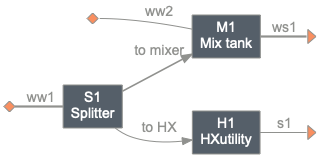

In [3]:
su = qs.sanunits
S1 = su.Splitter('S1', ins=ww1, outs=('to_HX', 'to_mixer'), split=0.2)
H1 = su.HXutility('H1', ins=S1-0, T=273.15+50)
M1 = su.MixTank('M1', ins=(S1-1, ww2), tau=2)
sys = qs.System('sys', path=(S1, H1, M1))
sys.simulate()
sys.diagram()

In [4]:
# Add some stream costs for TEA
ww1.price = ww2.price = 0.1
tea = qs.SimpleTEA(sys, lifetime=10)

In [5]:
# Add some stream impacts for LCA
GWP = qs.ImpactIndicator('GWP', unit='kg CO2')
ww_item1 = qs.StreamImpactItem('ww_item1', linked_stream=ww1, GWP=0.1)
ww_item2 = ww_item1.copy('ww_item2', stream=ww2)

In [6]:
# Let's also consider some construction impacts,
# assume we need 5000 kg of stainless steel per m3 of reactor,
# and the impact of is 4 kg CO2/kg stainless steel
StainlessSteel = qs.ImpactItem('StainlessSteel', functional_unit='kg', GWP=4)
M1_ss = qs.Construction('M1_ss', item=StainlessSteel)
M1.construction = (M1_ss,)

In [7]:
# Instead of making a subclass of `MixTank` to add the impacts,
# we can do so on the fly
old_M1_design = M1._design
def new_M1_design():
    old_M1_design() # we firstly call the origin design method
    M1_ss.quantity = M1.design_results['Total volume'] * 5000 # 5000 is just the assumed density
    M1.add_construction()
M1._design = new_M1_design # in this line we pass the new design method to M1

---
### Serious digression

Since I havent' thrown in a joke for a while...

In [8]:
# I was trying to find a good meme for "on the fly"
# expecting some funny versin of
from IPython.display import Image
Image(url='https://thesaurus.plus/img/synonyms/183/do_on_the_fly.png')

In [9]:
# But for some reason I found tons of, but the actual animal that we
# well... don't really like
Image(url='https://images-na.ssl-images-amazon.com/images/I/910v4vftdcL.jpg', width=400)

In [10]:
# So I tried something more straightforward,
# typed in "on the fly meme" in the almighty Google
# and... (see it on your own if you want, and no comments from me)
# Image(url='https://i2.wp.com/comicsandmemes.com/wp-content/uploads/fly-on-vice-president-mike-pences-head-debate-meme-who-wore-it-best-hillary-clinton-mike-pence-debate-fly.jpg?resize=768%2C576&ssl=1', width=400)

---

In [11]:
# Also let's add in the impacts for electricity
Electricity = qs.ImpactItem('Electricity', functional_unit='kWh', GWP=0.1)

In [12]:
# Finally the LCA
lca = qs.LCA(sys, lifetime=10,
             # The electricity is in kWh/yr, so multiply by the lifetime
             Electricity=lambda:sys.get_electricity_consumption()*10)

/Users/yalinli_cabbi/opt/anaconda3/envs/demo/lib/python3.8/site-packages/biosteam/_unit.py:697: RuntimeWarning: the purchase cost item, 'StainlessSteel', has no defined bare-module factor in the 'MixTank.F_BM' dictionary; bare-module factor now has a default value of 1
  warn(warning)


### 1.2. Create a system model and add uncertainty parameters and metrics
The `Model` class is used to enable uncertainty and sensitivity analyses, so we need to firstly create a model for our system.

In [13]:
model = Model(sys)

Uncertainty parameters can be added using the `model.parameter` method. Let's assume we are unsure of the price of wastewater, electricity, the impact characterization factor of stainless steel and electricity, as well as the split ratio of the splitter and temperature of the heat exchanger.

In [14]:
# We use the package `chaospy` to create distributions
from chaospy import distributions as shape

In [15]:
# There are multiple ways we can use the `parameter` method,
# but I like the following one most
param = model.parameter

dist = shape.Uniform(lower=0.05, upper=0.15)
@param(name='Wastewater price',
       element='TEA', # `element` determine which portion of the system will be simulated
       # `kind` determines whether the value will be included in simulation
       kind='isolated', 
       units='USD/kg',
       baseline=ww1.price, distribution=dist)
def set_ww_price(i): # here this `set_ww_price` is the `setter` function that will update the price
    ww1.price = ww2.price = i

In [16]:
# This will be another way to add parameters
baseline = PowerUtility.price
dist = shape.Triangle(lower=baseline*0.9, midpoint=baseline, upper=baseline*1.1)

# The setter function
def e_setter(i):
    PowerUtility.price = i
    
param(setter=e_setter, name='Electricity price', kind='isolated', element='TEA',
      units='USD/kWh', baseline=baseline, distribution=dist)

<Parameter: [TEA] Electricity price (USD/kWh)>

In [17]:
# Then impact factors
baseline = StainlessSteel.CFs['GWP']
dist = shape.Uniform(lower=baseline*0.9, upper=baseline*1.1)
@param(name='Stainless steel GWP', element='LCA', kind='isolated', 
       units='kg CO2/kg', baseline=baseline, distribution=dist)
def set_ss_GWP(i):
    StainlessSteel.CFs['GWP'] = i
    
baseline = Electricity.CFs['GWP']
dist = shape.Uniform(lower=baseline*0.9, upper=baseline*1.1)
@param(name='Electricity GWP', element='LCA', kind='isolated', 
       units='kg CO2/kg', baseline=baseline, distribution=dist)
def set_e_GWP(i):
    Electricity.CFs['GWP'] = i

In [18]:
# And finally the split ratio and heat exchanger temperature,
# `kind` need to be "coupled" for them because these two parameters
# would affect mass/energy balance (e.g., they are used in the `_run` method)
dist = shape.Triangle(lower=0.1, midpoint=0.2, upper=0.3)
@param(name='S1 split', element=S1, kind='coupled', 
       units='-', baseline=0.2, distribution=dist)
def set_S1_split(i):
    S1.split = i

baseline = H1.T
# `midpoint` doesn't need to be the same as the baseline
dist = shape.Triangle(lower=baseline-5, midpoint=baseline+1, upper=baseline*1.1)
@param(name='H1 temperature', element=H1, kind='coupled', 
       units='°C', baseline=baseline, distribution=dist)
def set_H1_T(i):
    H1.T = i

In [19]:
# Now it's time to add metrics!
# Of course we are interested in the net earnings and total GWP,
# again showing two ways to add metrics
metric = model.metric
@metric(name='Net earning', units='USD/yr', element='TEA')
def get_annual_net_earnings():
    return tea.net_earnings

# Again two ways to do so
def get_annual_GWP():
    return lca.total_impacts['GWP']/lca.lifetime
metric(getter=get_annual_GWP, name='GWP', units='kg CO2/yr', element='LCA')

<Metric: [LCA] GWP (kg CO2/yr)>

In [20]:
model

Model: TEA net earning [USD/yr]
       LCA GWP [kg CO2/yr]
 Element:      Parameter:
 TEA           Wastewater price
               Electricity price
 LCA           Stainless steel GWP
               Electricity GWP
 Splitter-S1   S1 split
 HXutility-H1  H1 temperature


[Back to top](#top)

## 2. Perform uncertainty and sensitivity analyses <a class="anchor" id="s2"></a>

### 2.1. Uncertainty analysis

In [21]:
# Once we have the model, Monte Carlo would be a breeze
import numpy as np
np.random.seed(3221) # setting the seed ensures you getting the same sample

# Let's say we want to perform 100 simulations
samples = model.sample(N=100, rule='L')
model.load_samples(samples)

In [22]:
# Let's do the simulation!
model.evaluate()

In [23]:
# Parameter values and metric results are stored in the `table` attribute
# model.table

In [24]:
# Here are some codes I often use to clean up the results
import pandas as pd
def organize_results(model, path):
    idx = len(model.parameters)
    parameters = model.table.iloc[:, :idx]
    results = model.table.iloc[:, idx:]
    percentiles = results.quantile([0, 0.05, 0.25, 0.5, 0.75, 0.95, 1])
    with pd.ExcelWriter(path) as writer:
        parameters.to_excel(writer, sheet_name='Parameters')
        results.to_excel(writer, sheet_name='Results')
        percentiles.to_excel(writer, sheet_name='Percentiles')

In [25]:
# You can run this to save the results
# organize_results(model, 'example_model.xlsx')

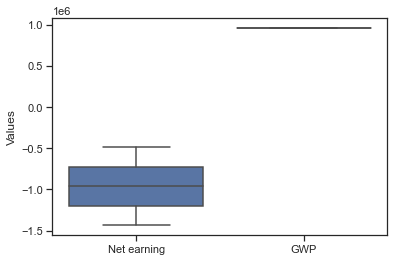

In [26]:
# You can have a quick look of the results by using the handy functions in the `stats` module
fig, ax = qs.stats.plot_uncertainties(model)
fig

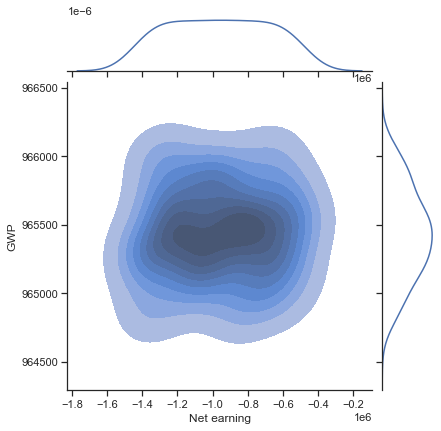

In [27]:
# There are some fancy plots
fig, ax = qs.stats.plot_uncertainties(model, x_axis=model.metrics[0], y_axis=model.metrics[1],
                                      kind='kde-kde', center_kws={'fill': True})
fig

### 2.2. Sensitivity analysis

QSDsan current has the following functions for sensitivity analysis:

- `get_correlations`

    - Spearman
    - Person
    - Kendall
    - Kolmogorov–Smirnov (KS)
    
- `morris_analysis`

    - There's also `morris_till_convergence` to increase the trajectory number until the results reach the set criterion or the trajectory number reaches the set maximum
    
- `fast_analysis` for Fourier amplitude sensitivity test (Saltelli's extended FAST) or random balance design (RBD) FAST
- `sobol_analysis`

For each of these methods, there is a corresponding `plot_XXX` (e.g., `plot_correlations` for `get_correlations`) method for visualization of the results.

In [28]:
# The documentation page of `stats` has some quite good examples,
# but let's just do a quick one here
# `r_df` and `p_df` are dataframes containing the sensitivity indices
# and p-values
r_df, p_df = qs.stats.get_correlations(model, kind='Spearman')

In [29]:
# You can see the price of wastewater drives the cost
# while the characterization factor of stainless steel drives the impacts
print(r_df, p_df)

Element                                                       TEA  \
Input y                                      Net earning [USD/yr]   
Element      Input x                                                
TEA          Wastewater price [USD/kg]                         -1   
             Electricity price [USD/kWh]                   0.0601   
LCA          Stainless steel GWP [kg CO2/kg]               0.0802   
             Electricity GWP [kg CO2/kg]                 -0.00583   
Splitter-S1  S1 split [-]                                  0.0398   
HXutility-H1 H1 temperature [°C]                         -0.00217   

Element                                                  LCA  
Input y                                      GWP [kg CO2/yr]  
Element      Input x                                          
TEA          Wastewater price [USD/kg]               -0.0506  
             Electricity price [USD/kWh]               0.124  
LCA          Stainless steel GWP [kg CO2/kg]           0.772  


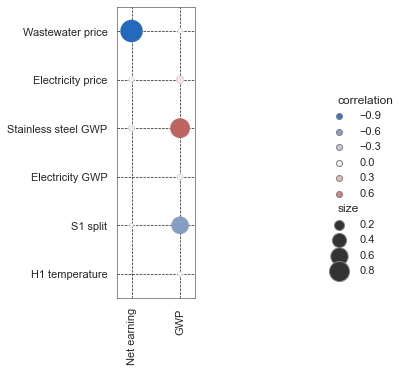

In [30]:
# The figure just makes it so much easier to grasp the results :p
fig, ax = qs.stats.plot_correlations(r_df)
fig

[Back to top](#top)